# Introduction to Gen's built-in modeling language

Explain that getting good results for inference sometimes requires inference programming. This notebook just uses a single generic inference algorithm for all problems. Inference programs will be discussed in later tutorials.

Also explain that there are various extensions to the modeling language, with better performance, that will be covered in later tutorials.

Explain that we use semicolons at the end of some cells to avoid printing the last expression, e.g.:

In [6]:
a = 1 + 1

2

In [7]:
a = 1 + 1;

## Loading packages

First, we load the Gen and PyPlot Julia packages.

In [2]:
using Gen
using PyPlot

┌ Info: Recompiling stale cache file /home/marcoct/.julia/compiled/v1.0/Gen/OEZG1.ji for Gen [ea4f424c-a589-11e8-07c0-fd5c91b9da4a]
└ @ Base loading.jl:1190


## Writing a probabilistic model

In [299]:
@gen function line_model(xs::Vector{Float64})
    n = length(xs)
    slope = @addr(normal(0, 1), :slope)
    intercept = @addr(normal(0, 2), :intercept)
    for (i, x) in enumerate(xs)
        @addr(normal(slope * x + intercept, 1), (:y, i))
    end
    return nothing
end;

In [300]:
xs = [-5., -4., -3., -.2, -1., 0., 1., 2., 3., 4., 5.];

In [301]:
(trace, _) = initialize(line_model, (xs,));

In [302]:
println(trace)

Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol,Any}(), Dict{Symbol,Any}(), Type[Array{Float64,1}], getfield(Main, Symbol("##257#259"))(), getfield(Main, Symbol("##258#260"))(), Bool[false], false), Trie{Any,Gen.ChoiceRecord}(Dict{Any,Gen.ChoiceRecord}((:y, 7)=>ChoiceRecord{Float64}(-0.0691359, -1.38717),(:y, 9)=>ChoiceRecord{Float64}(3.15508, -2.52493),(:y, 1)=>ChoiceRecord{Float64}(-1.1287, -1.12015),(:y, 10)=>ChoiceRecord{Float64}(0.377972, -1.65955),(:y, 5)=>ChoiceRecord{Float64}(-1.00462, -1.95414),(:y, 4)=>ChoiceRecord{Float64}(0.97527, -0.982051),:intercept=>ChoiceRecord{Float64}(0.666419, -1.6676),(:y, 3)=>ChoiceRecord{Float64}(-1.33286, -1.76762),(:y, 6)=>ChoiceRecord{Float64}(1.41318, -1.19777),(:y, 8)=>ChoiceRecord{Float64}(-0.207492, -1.81435),(:y, 11)=>ChoiceRecord{Float64}(1.24534, -1.08821),(:y, 2)=>ChoiceRecord{Float64}(-0.563425, -0.96431),:slope=>ChoiceRecord{Float64}(0.232152, -0.945886)), Dict{Any,Trie{Any,Gen.ChoiceRecord}}()), Trie

In [303]:
println(get_args(trace))

([-5.0, -4.0, -3.0, -0.2, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0],)


In [304]:
println(get_assmt(trace))

│
├── (:y, 7) : -0.06913594121102529
│
├── (:y, 9) : 3.1550761574620614
│
├── (:y, 1) : -1.1286994158683785
│
├── (:y, 10) : 0.3779722305049442
│
├── (:y, 5) : -1.0046209506371173
│
├── (:y, 4) : 0.9752695915987536
│
├── :intercept : 0.6664188913132143
│
├── (:y, 3) : -1.3328633924299746
│
├── (:y, 6) : 1.413181569232577
│
├── (:y, 8) : -0.20749183977761132
│
├── (:y, 11) : 1.2453381175130651
│
├── (:y, 2) : -0.5634245822363355
│
└── :slope : 0.2321515804909025



In [305]:
println(get_retval(trace));

ArgumentError: ArgumentError: `nothing` should not be printed; use `show`, `repr`, or custom output instead.

In [306]:
function render_trace(trace; show_data=true)
    xs = get_args(trace)[1]
    assmt = get_assmt(trace)
    if show_data
        ys = [assmt[(:y, i)] for i=1:length(xs)]
        scatter(xs, ys, c="black")
    end
    slope = assmt[:slope]
    intercept = assmt[:intercept]
    xmin = minimum(xs)
    xmax = maximum(xs)
    plot([xmin, xmax], slope *  [xmin, xmax] .+ intercept, color="black", alpha=0.5)
    ax = gca()
    ax[:set_xlim]((xmin, xmax))
    ax[:set_ylim]((xmin, xmax))
end;

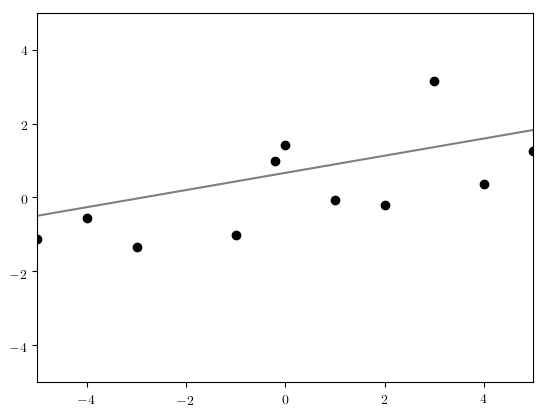

In [307]:
render_trace(trace);

In [308]:
traces = [initialize(line_model, (xs,))[1] for _=1:12];

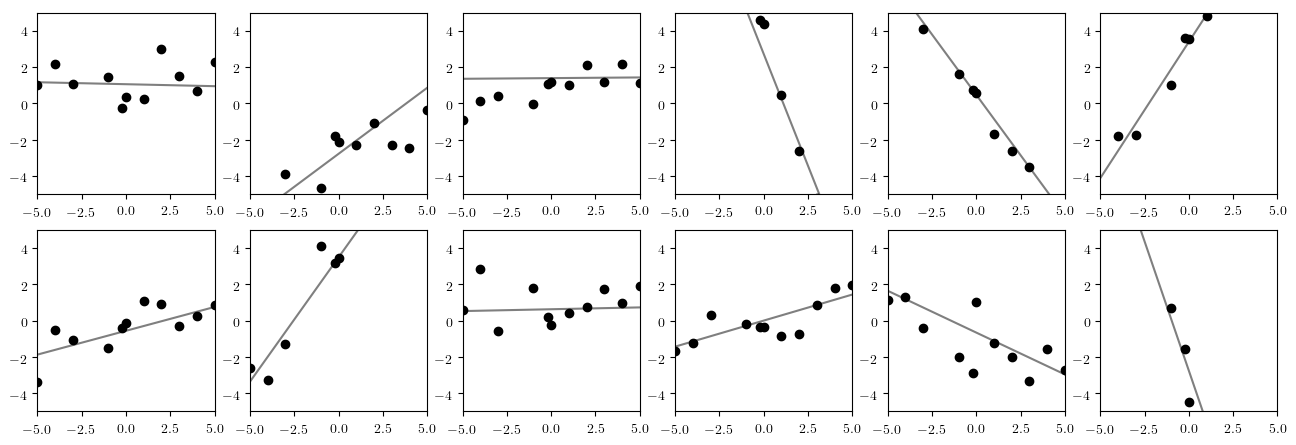

In [309]:
figure(figsize=(16, 8))
for (i, trace) in enumerate(traces)
    subplot(3, 6, i)
    render_trace(trace)
end

### Exercise
write a model that genreates sine waves of unknown phase, period and amplitude.
hint: use a gamma(1, 1) distribution for the prior on period and amplitude, and a uniform distribution for the phase

GOAL: teach them to modify a model program, and use Julia

In [310]:
@gen function sine_model(xs::Vector{Float64})
    period = @addr(gamma(1, 1), :period)
    amplitude = @addr(gamma(1, 1), :amp)
    phase = @addr(uniform(0, 2*pi), :phase)
    for (i, x) in enumerate(xs)
        @addr(normal(amplitude * sin(x * (2 * pi / period) + phase), 0.1), (:y, i))
    end
    return nothing
    end;

In [311]:
function render_sine_trace(trace; show_data=true)
    xs = get_args(trace)[1]
    assmt = get_assmt(trace)
    if show_data
        ys = [assmt[(:y, i)] for i=1:length(xs)]
        scatter(xs, ys, c="black")
    end
    period = assmt[:period]
    amp = assmt[:amp]
    phase = assmt[:phase]
    xmin = minimum(xs)
    xmax = maximum(xs)
    test_xs = collect(range(-5, stop=5, length=100))
    plot(test_xs, amp * sin.(test_xs * (2 * pi / period) .+ phase), color="black", alpha=0.5)
    ax = gca()
    ax[:set_xlim]((xmin, xmax))
    ax[:set_ylim]((xmin, xmax))
end;

In [312]:
traces = [initialize(sine_model, (xs,))[1] for _=1:12];

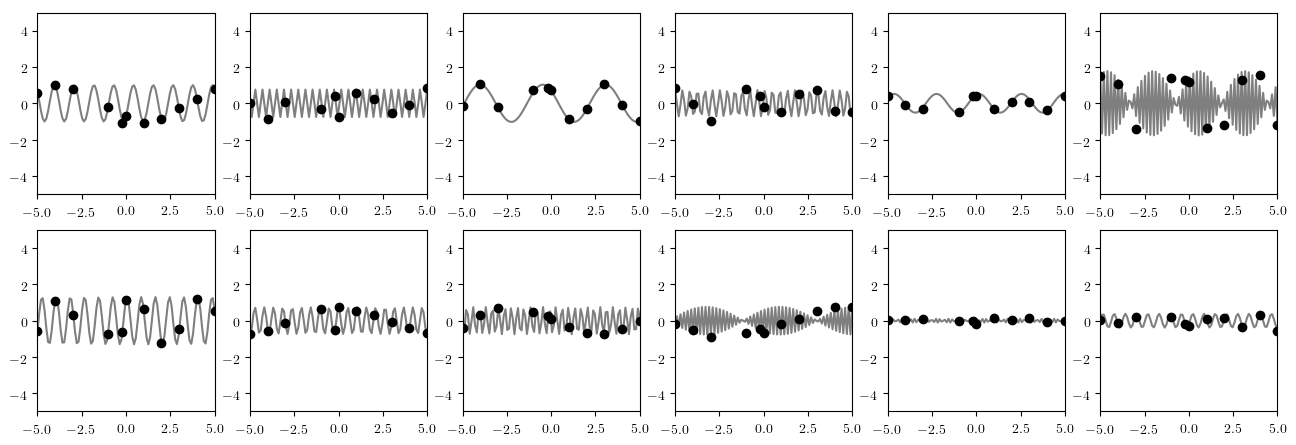

In [313]:
figure(figsize=(16, 8))
for (i, trace) in enumerate(traces)
    subplot(3, 6, i)
    render_sine_trace(trace)
end

## Doing Bayesian inference

In [314]:
ys = xs * -1 .+ 2 .+ randn(length(xs)) * 0.5;

In [315]:
function do_inference(model, xs, ys, num_samples)
    observations = DynamicAssignment()
    for (i, y) in enumerate(ys)
        observations[(:y, i)] = y
    end
    (trace, _) = importance_resampling(model, (xs,), observations, num_samples);
    return trace
end;

In [320]:
trace = do_inference(line_model, xs, ys, 100);

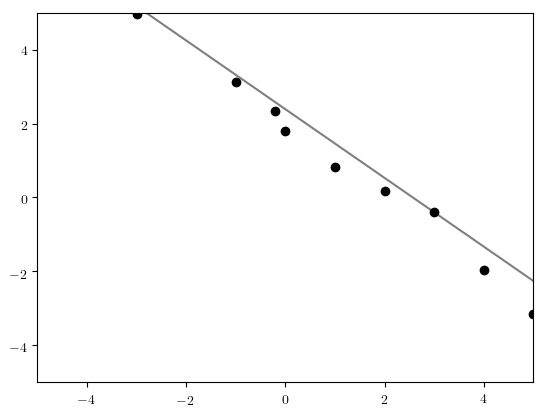

(-5.0, 5.0)

In [321]:
render_trace(trace)

In [327]:
function overlay(renderer, traces)
    renderer(traces[1], show_data=true)
    for i=2:length(traces)
        renderer(traces[i], show_data=false)
    end
end;

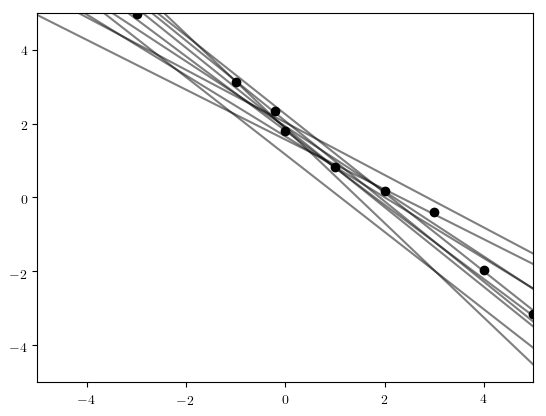

In [328]:
traces = [do_inference(line_model, xs, ys, 100) for _=1:10];
overlay(render_trace, traces)

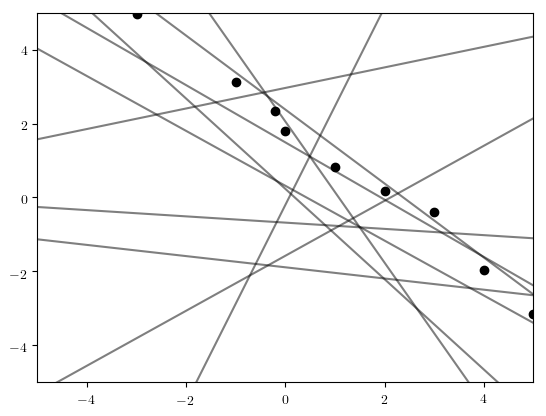

In [329]:
traces = [do_inference(line_model, xs, ys, 1) for _=1:10];
overlay(render_trace, traces)

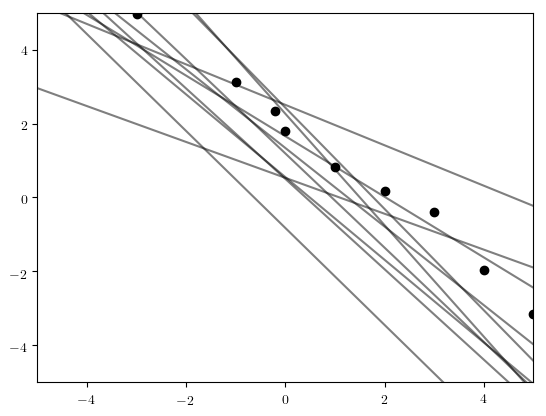

In [330]:
traces = [do_inference(line_model, xs, ys, 10) for _=1:10];
overlay(render_trace, traces)

### Exercise
for the sine wave model, run inference for the following data set how many iterations do you need to get good results?
compare with inference results for the original model 'model'.
interpret the results. change the prior on the period

In [333]:
#ys = 3 * sin.(xs) + randn(length(xs)) * 0.1;
ys = [2.89, 2.22, -0.612, -0.522, -2.65, -0.133, 2.70, 2.77, 0.425, -2.11, -2.76];

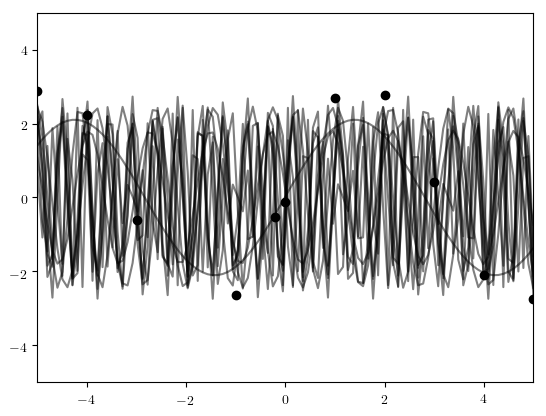

In [337]:
traces = [do_inference(sine_model, xs, ys, 1000) for _=1:10];
overlay(render_sine_trace, traces)

In [338]:
@gen function sine_model_new(xs::Vector{Float64})
    period = @addr(gamma(3, 1), :period)
    amplitude = @addr(gamma(1, 1), :amp)
    phase = @addr(uniform(0, 2*pi), :phase)
    for (i, x) in enumerate(xs)
        @addr(normal(amplitude * sin(x * (2 * pi / period) + phase), 0.1), (:y, i))
    end
    return nothing
    end;

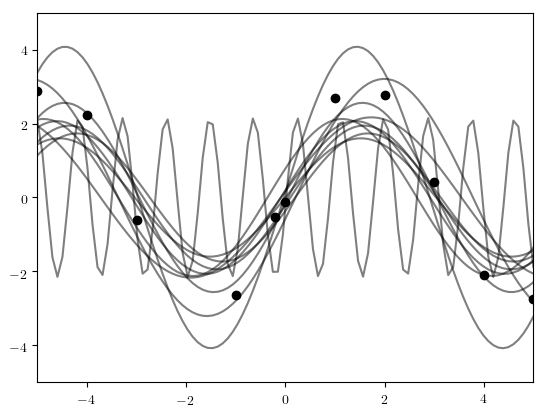

In [342]:
traces = [do_inference(sine_model_new, xs, ys, 1000) for _=1:10];
overlay(render_sine_trace, traces)

### Exercise
here is a data set.
what do you expect the posterior for for the linear_model
this data set to look like?
run inference, is that what you expected?
how can you make it more uncertain?
hint: make the noise variable be sampled from a gamma(1, 1) distribution.
visualize the results to confirm.

In [364]:
ys = randn(length(xs)) * 2;

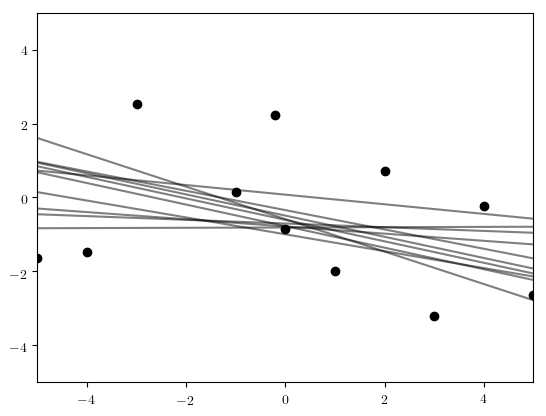

In [365]:
traces = [do_inference(line_model, xs, ys, 1000) for _=1:10];
overlay(render_trace, traces)

In [366]:
@gen function line_model_new(xs::Vector{Float64})
    n = length(xs)
    slope = @addr(normal(0, 1), :slope)
    intercept = @addr(normal(0, 2), :intercept)
    noise = @addr(gamma(1, 1), :noise)
    for (i, x) in enumerate(xs)
        @addr(normal(slope * x + intercept, noise), (:y, i))
    end
    return nothing
end;

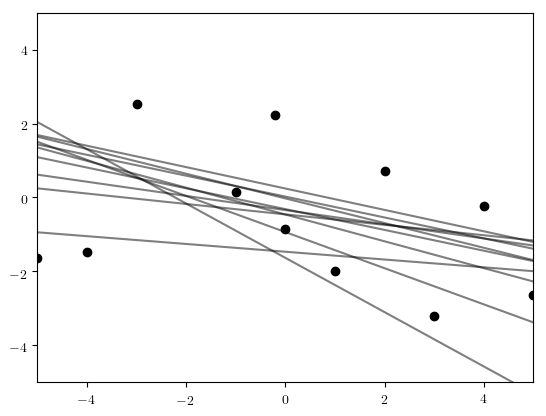

In [367]:
traces = [do_inference(line_model_new, xs, ys, 10000) for _=1:10];
overlay(render_trace, traces)

Also make the sine model noise a random choice, and re-run the results of inference.

In [379]:
@gen function sine_model_3(xs::Vector{Float64})
    period = @addr(gamma(3, 1), :period)
    amplitude = @addr(gamma(1, 1), :amp)
    phase = @addr(uniform(0, 2*pi), :phase)
    noise = @addr(gamma(1, 1), :noise)
    for (i, x) in enumerate(xs)
        @addr(normal(amplitude * sin(x * (2 * pi / period) + phase), noise), (:y, i))
    end
    return nothing
end;

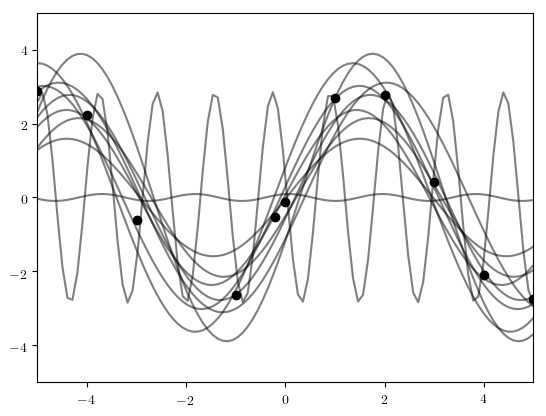

In [398]:
ys = [2.89, 2.22, -0.612, -0.522, -2.65, -0.133, 2.70, 2.77, 0.425, -2.11, -2.76];
traces = [do_inference(sine_model_3, xs, ys, 1000) for _=1:10];
overlay(render_sine_trace, traces)

## Invoking other generative functions
show a generative function that calls another generative function.
show that you can also use splice.

In [399]:
@gen function combined_model(xs::Vector{Float64})
    if @addr(bernoulli(0.5), :is_line)
        @splice(line_model_new(xs))
    else
        @splice(sine_model_3(xs))
    end
end;

In [400]:
function render_either(trace; show_data=true)
    assmt = get_assmt(trace)
    if assmt[:is_line]
        render_trace(trace, show_data=show_data)
    else
        render_sine_trace(trace, show_data=show_data)
    end
end;

In [401]:
traces = [initialize(combined_model, (xs,))[1] for _=1:12];

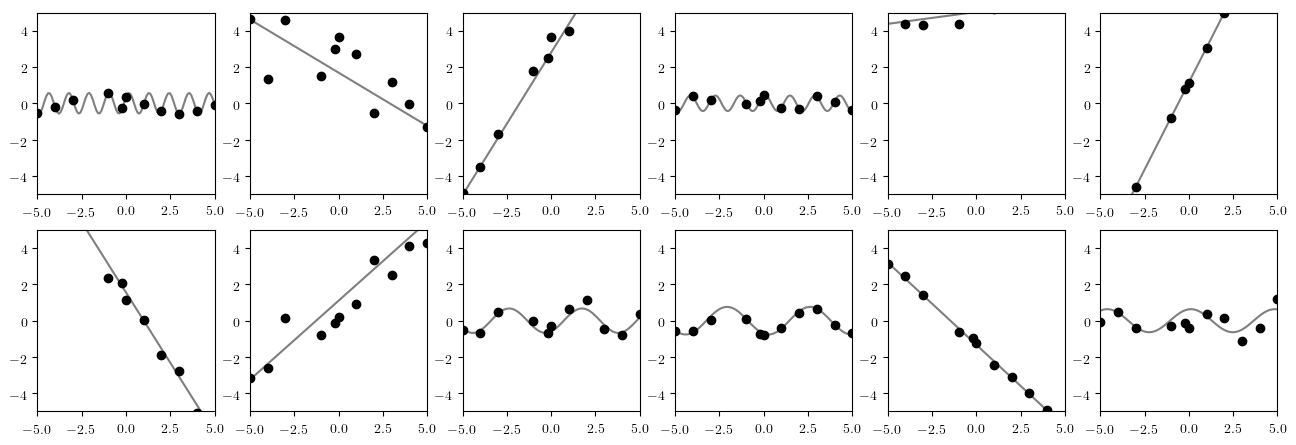

In [402]:
figure(figsize=(16, 8))
for (i, trace) in enumerate(traces)
    subplot(3, 6, i)
    render_either(trace)
end

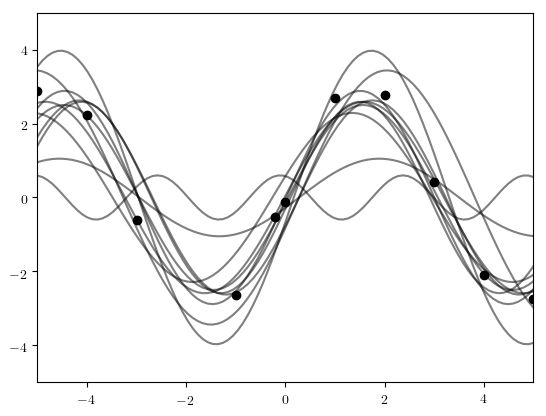

In [405]:
ys = [2.89, 2.22, -0.612, -0.522, -2.65, -0.133, 2.70, 2.77, 0.425, -2.11, -2.76];
traces = [do_inference(combined_model, xs, ys, 10000) for _=1:10];
overlay(render_either, traces)

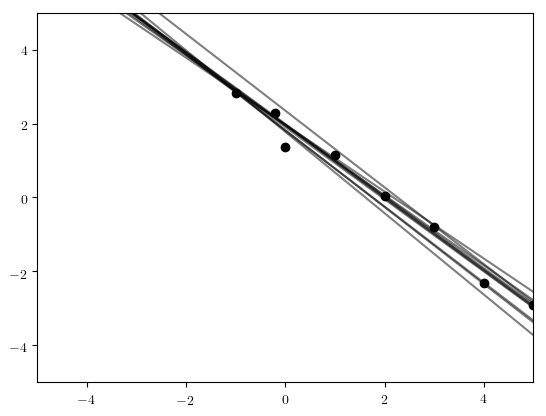

In [406]:
ys = xs * -1 .+ 2 .+ randn(length(xs)) * 0.5;
traces = [do_inference(combined_model, xs, ys, 10000) for _=1:10];
overlay(render_either, traces)

### Exercise 
There is code duplication in the two models. Can you refactor the model?

In [408]:
@gen function line_model_refactored()
    slope = @addr(normal(0, 1), :slope)
    intercept = @addr(normal(0, 2), :intercept)
    return (x) -> slope * x + intercept
end;

In [409]:
@gen function sine_model_refactored()
    period = @addr(gamma(3, 1), :period)
    amplitude = @addr(gamma(1, 1), :amp)
    phase = @addr(uniform(0, 2*pi), :phase)
    return (x) -> amplitude * sin(x * (2 * pi / period) + phase)
end;

In [415]:
@gen function combined_model_refactored(xs::Vector{Float64})
    if @addr(bernoulli(0.5), :is_line)
        mean_fn = @addr(line_model_refactored(), :line_model)
    else
        mean_fn = @addr(sine_model_refactored(), :sine_model)
    end
    noise = @addr(gamma(1, 1), :noise)
    for (i, x) in enumerate(xs)
        @addr(normal(mean_fn(x), noise), (:y, i))
    end
    return mean_fn;
end;

In [419]:
function render_either_refactored(trace; show_data=true)
    xs = get_args(trace)[1]
    mean_fn = get_retval(trace)
    assmt = get_assmt(trace)
    if show_data
        ys = [assmt[(:y, i)] for i=1:length(xs)]
        scatter(xs, ys, c="black")
    end
    xmin = minimum(xs)
    xmax = maximum(xs)
    test_xs = collect(range(-5, stop=5, length=100))
    plot(test_xs, map(mean_fn, test_xs), color="black", alpha=0.5)
    ax = gca()
    ax[:set_xlim]((xmin, xmax))
    ax[:set_ylim]((xmin, xmax))
end;

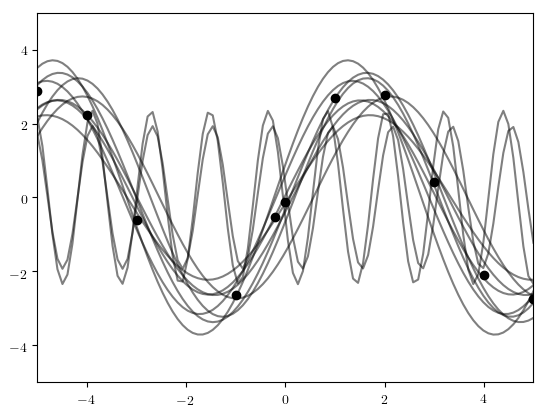

In [420]:
ys = [2.89, 2.22, -0.612, -0.522, -2.65, -0.133, 2.70, 2.77, 0.425, -2.11, -2.76];
traces = [do_inference(combined_model_refactored, xs, ys, 10000) for _=1:10];
overlay(render_either_refactored, traces)

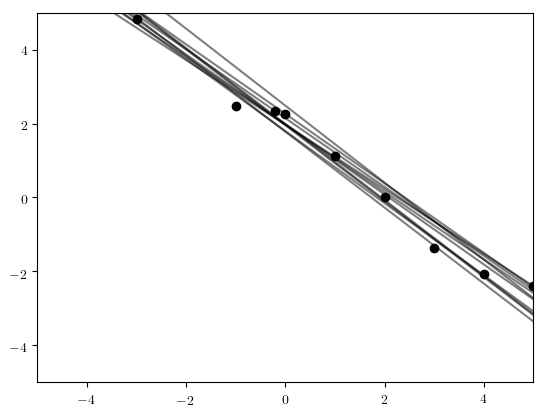

In [421]:
ys = xs * -1 .+ 2 .+ randn(length(xs)) * 0.5;
traces = [do_inference(combined_model, xs, ys, 10000) for _=1:10];
overlay(render_either, traces)

## Compositional discrete hypothesis spaces

### Exercise
implement a generative function that samples strings from a probabilistic context-free grammar using recursion
first do a version that uses `addr` and then a version that uses `splice`.
Q: compute the probability that the string is length 1 as a function of p
Q: are their values of p for which the probability of any string is not 1?